#by luis.bazo@gmail.com

# Introduction

This script reads a csv file with telemetry values from vehicules and performs different Machine Learning models to predict vehicule failures. Several models are assessed to 

## Main steps performed during the script

 1. Read the data from csv and initiate panda dataframe with the information
 2. Transform data columns types into readable values by ML models (strings are mapped as objects and they can't be read by models)
 3. Remove highly correlated columns. They don't provide any value to the model and reduce the efficiency and increase processing time
 4. Assess majority class balance
 
      a. Given that false failures are highly predominant, downsample majority class to balance possitive and negative
      
      b. Scale data to standarize features magnitudes. That improves ML model training.
 
 
 5. Split train dataset in train and test datasets respectivelly. Test dataset represents the 25% of the train dataset. 
 6. Train/Fit models and get predicted values for the test dataset. A separate thread is created for every single model trainin run.
 7. Plot different metrics with models performance and compare model calibration
 
 Please note: The Machine Learning models used for this exercise are the ones provided by the sklearn library of Python.


In [1]:
%matplotlib inline
import pandas as pd
from sklearn import preprocessing as scale
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.utils import resample
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve, precision_score,f1_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score as AUC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from threading import Lock, Thread
from sklearn.decomposition import PCA
import sys
import warnings

# Script general configuration
Several variables are defined to store the metrics resulting from the model training performed. 

There is also the list of binary classification models to be used for training. It can be easily changed to add new models or removed the ones not interested in. 

In [2]:
#Disable warnings. That lines should be commmented if we want warnings to be displayed
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
#Variables to be used 
accuracy_values = list()
accuracy_columns = list()
recall_values = list()
recall_columns = list()
precision_values = list()
precision_columns = list()
average_precision_values = list()
average_precision_columns = list()
f1_values = list()
f1_columns = list()
prob_pos = pd.DataFrame()

model_names = ["Nearest_Neighbors", "SVC", "Gaussian_Process",
         "Decision_Tree", "Random_Forest", "Neural_Net", "AdaBoost",
         "Naive_Bayes", "QDA", "Logistic_Regression"]
models = [    
    KNeighborsClassifier(),
    SVC(),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]


# Load CSV file into python panda dataframe

The CSV provided for training is loaded into a panda dataframe. Dataframes provide capabilities to easy data transformations, remove not relevant columns (features), normalize data, etc.

In [3]:

#loading csv file into python
dataset = pd.read_csv('./device_failure.csv',encoding='unicode_escape')

In [4]:
dataset.head(100)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
5,2015-01-01,S1F01TD5,0,68837488,0,0,41,6,413535,0,0,1
6,2015-01-01,S1F01XDJ,0,227721632,0,0,0,8,402525,0,0,0
7,2015-01-01,S1F023H2,0,141503600,0,0,1,19,494462,16,16,3
8,2015-01-01,S1F02A0J,0,8217840,0,1,0,14,311869,0,0,0
9,2015-01-01,S1F02DZ2,0,116440096,0,323,9,9,407905,0,0,164


# Initial data analysis

Check data types mapped in dataset columns

In [5]:
dataset.dtypes

date          object
device        object
failure        int64
attribute1     int64
attribute2     int64
attribute3     int64
attribute4     int64
attribute5     int64
attribute6     int64
attribute7     int64
attribute8     int64
attribute9     int64
dtype: object

Transform objects into readable types by Machine Learning sklearn models

In [6]:
le = scale.LabelEncoder()
dataset['device'] = le.fit_transform(dataset['device'])
#dataset['date'] = le.fit_transform(dataset['date'])
dataset['date'] = pd.to_datetime(dataset['date'])

#Remove rows with NA column information. Model don't work well with NA values
dataset.dropna(axis=0,inplace=True)
dataset.dtypes

date          datetime64[ns]
device                 int32
failure                int64
attribute1             int64
attribute2             int64
attribute3             int64
attribute4             int64
attribute5             int64
attribute6             int64
attribute7             int64
attribute8             int64
attribute9             int64
dtype: object

In [7]:
dataset.describe()

,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,622.379191,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,327.177800,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,378.000000,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,602.000000,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,917.000000,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1168.000000,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


Run correlation method that removes higly related columns (over 80%). 
Similar features do not contribute to model performance and it makes it slower to train.

In [8]:
def corr_df(x, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''
    
    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns))
    drop_cols = []
    
    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i):(i+1)]
            col = item.columns
            row = item.index
            val = item.values
            if val >= corr_val:
                # Prints the correlated feature set and the corr val
                print("Related columns have been found " , col.values[0], "|", row.values[0], "| with correlation coeficient ", round(val[0][0], 2))
                print("Removing column ", col.values[0], " from dataset")
                drop_cols.append(col.values[0])
  

    # Drops the correlated columns
    df = x.drop(drop_cols, axis=1)
    return df

In [9]:
#Remove high correlated columns/features
data = corr_df (dataset,0.8)
data.describe()

Related columns have been found  attribute8 | attribute7 | with correlation coeficient  1.0
Removing column  attribute8  from dataset


,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124494.000000,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,622.379191,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,12.451524
std,327.177800,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,191.425623
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000
25%,378.000000,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000
50%,602.000000,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000
75%,917.000000,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000
max,1168.000000,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,18701.000000


Perform initial analysis on column date which was initially an object. 
According to the graph below, there seems there is not any relation between the date and the failure. 

Note: The feature is removed from the model training but it might be worth to have a conversation with the customer to figure out the real meaning of this feature.

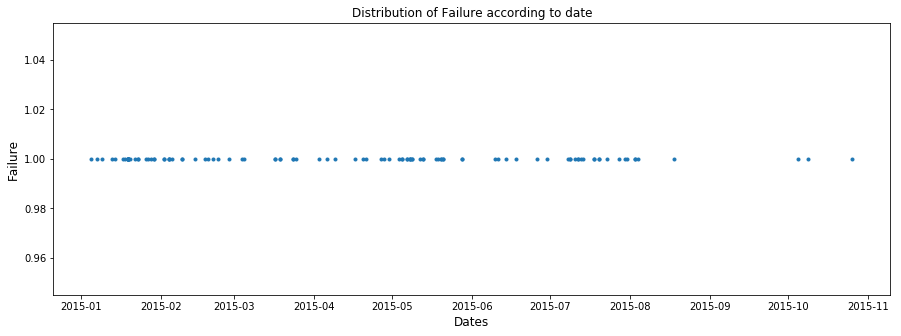

In [10]:
Failure = data[data.failure==1]
notRelevantColumns = ['failure']
    
#Initial data analysis on feature date agains failure
plt.figure(figsize=(15,5))
plt.plot(Failure['date'].sort_values(),Failure['failure'],".")
plt.title("Distribution of Failure according to date")
plt.ylabel('Failure', fontsize=12)
plt.xlabel('Dates', fontsize=12)

#Remove date, assuming is installation date, as it there seems to be not relation with failure
notRelevantColumns.extend(['date'])


Assess majority class balance. For this specific case, the number of possitives and negative should be balanced otherwise the model will be too much influenced by samples of one class (majority) while the other (minotiry) remains irrelevant for predictions 

For this specific case, as the number of negatives is much longer that possitives we downsample negatives to meet possitive numbers

As magnitures of different features might vary significantly data is standarized and features are scaled near 0 value. That technique improves model training. 

PCA (Principal component analysis) has been commented in the code as it has not being identified any feature within the resulting ones after the downsampling that could be potentially discarded because of having a very low variance ratio

Finally, dataset is splitted into train and test datasets. It's exactrated the 25% of the dataset to perform the test of the trained model

In [11]:
def MajorityClassIsBalanced (data,feature):
    for i in data[feature].value_counts(normalize=True).tolist():
        if (i < 0.6):
            return False

In [12]:
#Downsample train data if needed to preserve train data balance as much as possible

if not MajorityClassIsBalanced (data,'failure'):
    
    #very low majority class occurrences -> downsampling data.
    df_nonfailure = data[data['failure'] == 0]
    df_failure = data[data['failure']==1]
    df_nonfailure_downsample = resample(df_nonfailure,replace=False,n_samples = 106,\
                                        random_state=23)
    df_resampled = pd.concat([df_nonfailure_downsample,df_failure])

    data_Outcome = df_resampled['failure']
    

    #dropping unwanted columns
    #That needs to be validated with customer as they might want to keep some of them
    df_resampled = df_resampled.drop(notRelevantColumns,axis = 1)
    standard_sc = scale.StandardScaler()
    x_std = standard_sc.fit_transform(df_resampled)
    data_scaled = pd.DataFrame(x_std)
    
    #pca = PCA()
    #principalComponents = pca.fit_transform(data_scaled)
    #principalDf = pd.DataFrame(data = principalComponents)
    #print (pca.explained_variance_ratio_)
    
    #split data into test and train
    xtrain,xtest,ytrain,ytest = train_test_split(data_scaled,data_Outcome,test_size=0.25,random_state =19)
    #xtrain,xtest,ytrain,ytest = train_test_split(principalDf,data_Outcome,test_size=0.25,random_state =19)
else:
    #dropping unwanted columns
    #That needs to be validated with customer as they might want to keep some of them
    data = data.drop(notRelevantColumns,axis = 1)
    standard_sc = scale.StandardScaler()
    x_std = standard_sc.fit_transform(data)
    data = pd.DataFrame(x_std)
    
    #pca = PCA()
    #principalComponents = pca.fit_transform(data)
    #principalDf = pd.DataFrame(data = principalComponents)
    #print (pca.explained_variance_ratio_)
    
    #split data into test and train
    xtrain,xtest,ytrain,ytest = train_test_split(data,data['failure'],test_size=0.25,random_state =19)
    
    

# Train models

Function to train the model and get predictions. Some metrics like accuracy, recall, precision, average precision and f1 score are stored to compare the different models that have been used and figure out what is the best.

To speed up model execution, a new execution thread is run for every single model executed

In [13]:
def runModel (model,model_name, xtrain, ytrain, xtest):
    '''
    runModel runs model fit and prediction for the train and test x,y dataframes provided 
    and extracts performance metrics from the model executed (accuracy, recall, precision, average precision, f1 and probability)
    
    Metric score values are made global to later use when plotting all the metrics together to compare them
    '''
    model_dt = model.fit(xtrain,ytrain)
    pred_dt=model_dt.predict(xtest)
    #Metrics(ytest,pred_dt)
    global accuracy_values
    global accuracy_columns
    global recall_values
    global recall_columns
    global precision_values
    global precision_columns
    global average_precision_values
    global average_precision_columns
    global f1_values
    global f1_columns
    global prob_pos
    accuracy_values.append(accuracy_score(ytest,pred_dt))
    accuracy_columns.append(model_name)
    recall_values.append(recall_score(ytest,pred_dt))
    recall_columns.append(model_name)
    precision_values.append(precision_score(ytest,pred_dt))
    precision_columns.append(model_name)
    f1_values.append(f1_score(ytest,pred_dt))
    f1_columns.append(model_name)
    average_precision_values.append(average_precision_score(ytest,pred_dt))
    average_precision_columns.append(model_name)
    if hasattr(model_dt, "predict_proba"):
        prob_pos[model_name] = model_dt.predict_proba(xtest)[:, 1]
    else:  # use decision function
        prob_pos[model_name] = model_dt.decision_function(xtest)
        prob_pos[model_name] = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    
    #print("********************** ", model_name, "*************************")
    #print(model_name, 'accuracy:', accuracy_score(ytest,pred_dt),',recall score:',recall_score(ytest,pred_dt))
    #print(model_name, 'precision: ', precision_score(ytest,pred_dt), ',av_precision_score: ', average_precision_score(ytest,pred_dt), ',f1_score: ', f1_score(ytest,pred_dt))
    #print(model_name, "\n", confusion_matrix(ytest,pred_dt))
    #print(model_dt.feature_importances_ )


In [14]:
#Run models creating a thread to run every single one. That speeds up the training process.
threads = list()


for model,model_name in zip(models,model_names):
    t = Thread(target=runModel, args=(model,model_name,xtrain,ytrain,xtest))
    threads.append(t)
    t.start()
    t.join()




# Compare model metrics

Function to print a graph to compare the model trained metrics. The metrics will show the performance of the models and how well the performed with the train data vs predictions achieved 

Several metrics are compare between models: 

Before going into explainig what means each of them we review some binary classification important concepts 

**True Positives (TP)** - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes. E.g. if actual class value indicates that the vehicle failed and the prediction tells you the same thing.

**True Negatives (TN)** - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no. E.g. if actual class says the vehicule failed and predicion tells you the same thing.

False positives and false negatives, these values occur when your actual class contradicts with the predicted class.

**False Positives (FP)** – When actual class is no and predicted class is yes. E.g. if actual class says that the vehicule did not failed but the prediction class tells you that the vehicle failed.

**False Negatives (FN)** – When actual class is yes but predicted class in no. E.g. if actual class value indicates the vehicle failed and predicted class tells you that the vehicule failed.

What metrics basically do is to relationate these values

**Accuracy** : Accuracy = TP+TN/TP+FP+FN+TN 

Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations.

**Recall** : Recall = TP/TP+FN

Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. It is a meassure of completness of the true predicted results vs actual ones. Others say this is the ratio of sensitivity. 

**F1** : F1 = 2*(Recall * Precision) / (Recall + Precision)

F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall

**Precission** : Precision = TP/TP+FP

Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.

One of the goals of this exercice is to find a model that maximizes the number of TP and TN. **Accuracy** would be a good metric to look at but for the completness of this exercise the rest of metrics are assessed as well.


In [15]:
def plot_metrics (name, x, y):
    
    
    metric = pd.DataFrame({'x': x, 'y': y})
    metric.sort_values(by='y',ascending=False,inplace=True)
    print ("*******Metric ", name , " ************\n",metric)

    # Plot the figure.
    plt.figure(figsize=(12, 8))
    ax = metric.y.plot(kind='barh')
    ax.set_title(name)
    ax.set_xlabel('Metric Value')
    ax.set_ylabel(name)
    ax.set_yticklabels(metric.x)
    ax.set_xlim(0, 1) # expand xlim to make labels easier to read

    rects = ax.patches

    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2

        # Number of points between bar and label. Change to your liking.
        space = 5
        # Vertical alignment for positive values
        ha = 'left'

        # If value of bar is negative: Place label left of bar
        if x_value < 0:
            # Invert space to place label to the left
            space *= -1
            # Horizontally align label at right
            ha = 'right'

        # Use X value as label and format number with one decimal place
        label = "{:.5f}".format(x_value)

        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(space, 0),          # Horizontally shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            va='center',                # Vertically center label
            ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.
    plt.show()

*******Metric  Accuracy  ************
                      x         y
3        Decision_Tree  0.867925
6             AdaBoost  0.867925
4        Random_Forest  0.830189
8                  QDA  0.811321
7          Naive_Bayes  0.773585
5           Neural_Net  0.698113
9  Logistic_Regression  0.698113
1                  SVC  0.566038
2     Gaussian_Process  0.566038
0    Nearest_Neighbors  0.471698


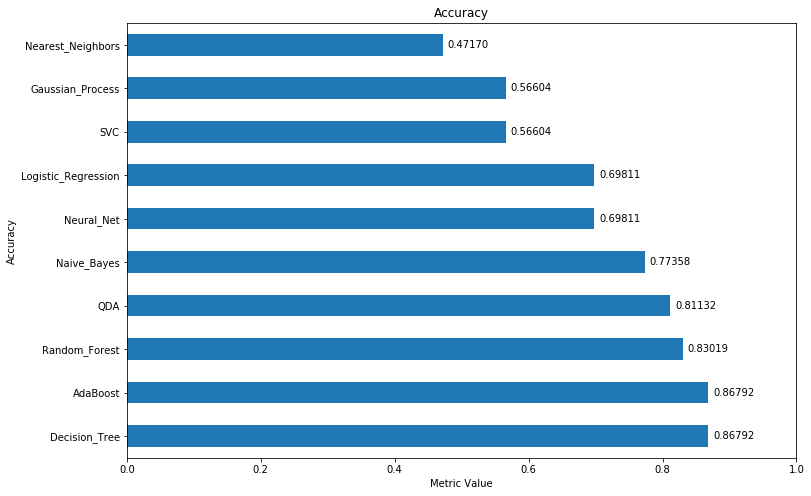

*******Metric  Recall  ************
                      x         y
3        Decision_Tree  0.793103
6             AdaBoost  0.793103
4        Random_Forest  0.724138
8                  QDA  0.655172
7          Naive_Bayes  0.586207
5           Neural_Net  0.517241
9  Logistic_Regression  0.448276
2     Gaussian_Process  0.344828
0    Nearest_Neighbors  0.310345
1                  SVC  0.275862


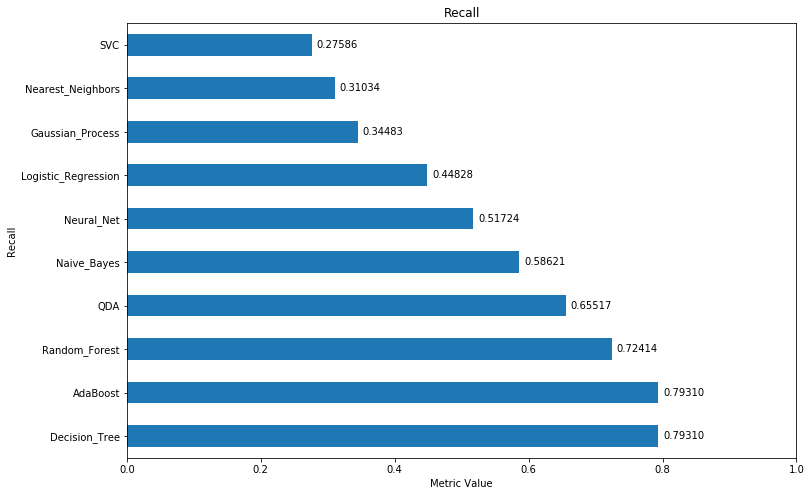

*******Metric  F1  ************
                      x         y
3        Decision_Tree  0.867925
6             AdaBoost  0.867925
4        Random_Forest  0.823529
8                  QDA  0.791667
7          Naive_Bayes  0.739130
5           Neural_Net  0.652174
9  Logistic_Regression  0.619048
2     Gaussian_Process  0.465116
1                  SVC  0.410256
0    Nearest_Neighbors  0.391304


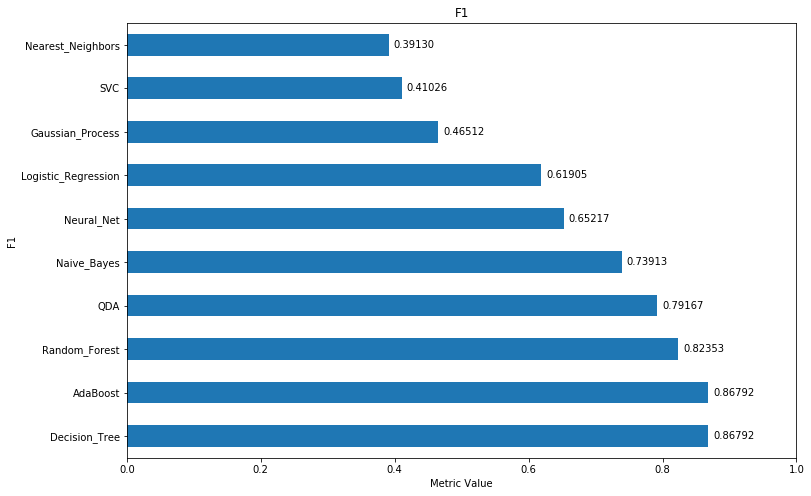

*******Metric  Presision  ************
                      x         y
7          Naive_Bayes  1.000000
8                  QDA  1.000000
9  Logistic_Regression  1.000000
3        Decision_Tree  0.958333
6             AdaBoost  0.958333
4        Random_Forest  0.954545
5           Neural_Net  0.882353
1                  SVC  0.800000
2     Gaussian_Process  0.714286
0    Nearest_Neighbors  0.529412


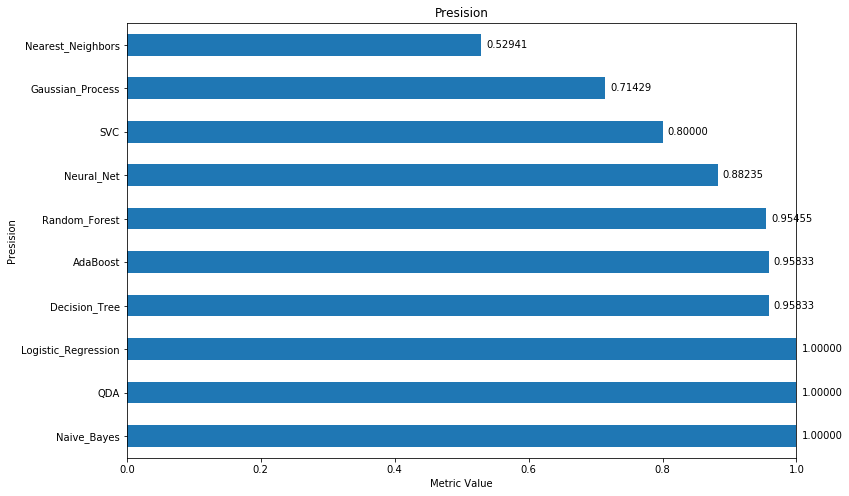

In [16]:
#Plot model metrics to assess ML model performance

plot_metrics("Accuracy",accuracy_columns,accuracy_values)
plot_metrics("Recall", recall_columns, recall_values)
plot_metrics("F1", f1_columns, f1_values)
#plot_metrics("Average Precision", average_precision_columns, average_precision_values)
plot_metrics("Presision", precision_columns, precision_values)

As an additional metric of model performance, it is assessed the model calibration which also looks at the probability of possitives comparing with the actual number of predicted possitives

In [17]:
def checkModelCalibration(X_train,X_test, y_train,y_test,models,model_name):
    
    plt.figure(figsize=(15, 15))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf,name in zip(models,model_names):
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos[name], n_bins=5)
    
        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s" % (name, ))
    
    ax1.set_ylabel("Fraction of positives")
    ax1.set_xlabel("Mean predicted value")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')
    
    plt.tight_layout()
    plt.show()

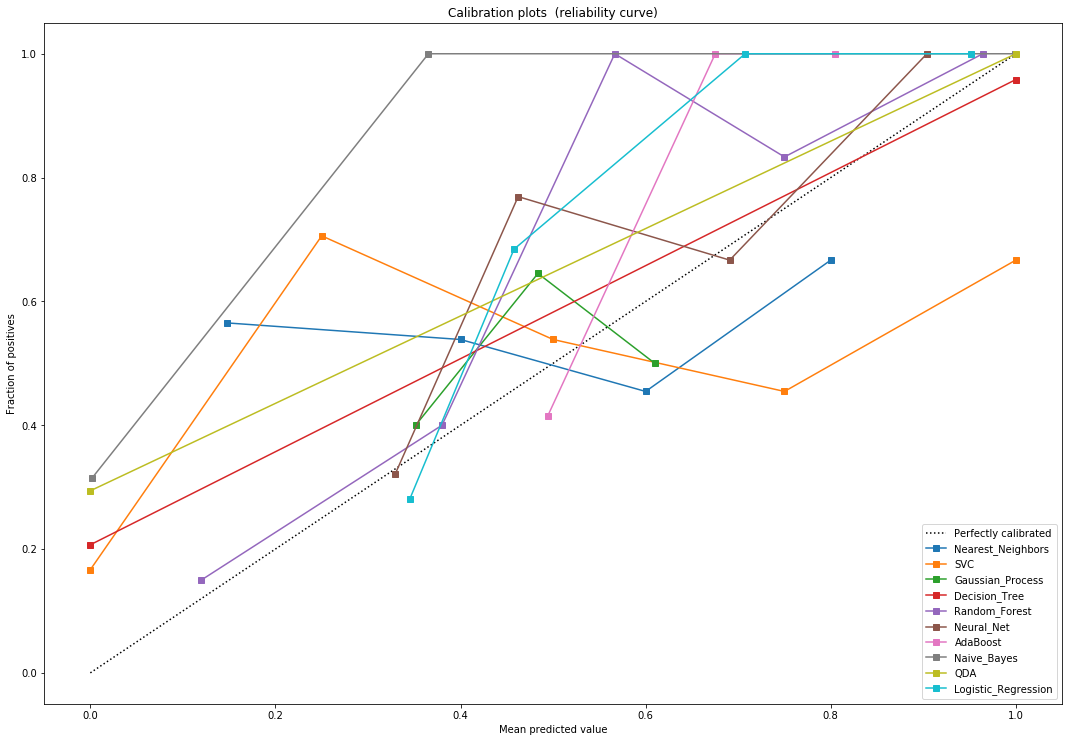

In [18]:
#Plot model calibration based in feature prediction probabilities as an additional metric of model performance
checkModelCalibration(xtrain,xtest, ytrain,ytest,models,model_name)

#Decision tree and Adaboost seems to be the best models with the train data that has been given for this exercise however
# Decision tree seems to be better callibrated

# Conclusion

As a conclusion **Decision tree** and **Adaboost** seem to be the best models in terms of **Accuracy** and calibration with the train data that has been provided for this exercise however better results could be obtained with larger datasets. 

For this specific case Decission tree might be the best model as there was no linear relation between features used for training. That same reason could have affected negativelly to the linear models performance however sometimes is hard to explain why one model behaves better than the other.  

As a general recommendation I would keep running the majority of the models unless there is no computing resources enought available to run the models.